In [1]:
### DRPreter Graph Embedding + PaDEL Descriptor + ResNet

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras import backend as K

In [2]:
import pandas as pd
train_data = pd.read_csv('/data/yingfei/cancer_data/train_data.csv')
test_data = pd.read_csv('/data/yingfei/cancer_data/test_data.csv')

In [3]:
from sklearn.model_selection import train_test_split
with open('./Data/train_celllines_v1_1111.txt') as f:
    train_index = list(map(lambda x: x[:-1],f.readlines()))
train_set_index, val_set_index = train_test_split(train_index, test_size=0.1, random_state=42)

In [4]:
train_data = train_data.loc[train_data['auc'] >= 0]
train_data = train_data.reset_index(drop = True)
train_data

,ARXSPAN_ID,DRUG_NAME,ABL1,ACVR1B,AKT1,AKT2,AKT3,ALK,ALOX12B,FAM123B,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,auc
0,ACH-000001,JW-7-24-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.778432
1,ACH-000001,KIN001-260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.951321
2,ACH-000001,NSC-87877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.840287
3,ACH-000001,PLX-4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.936410
4,ACH-000001,ERK5-IN-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.891908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203913,ACH-001716,KIN001-236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.956865
203914,ACH-001716,LUMINESPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.975168
203915,ACH-001716,NUTLIN-3A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.871995
203916,ACH-001716,SGC0946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.975417


In [5]:
train_data_new = train_data.loc[train_data.ARXSPAN_ID.isin(train_set_index)].copy()
train_data_new = train_data_new.reset_index(drop = True)
val_data_new = train_data.loc[train_data.ARXSPAN_ID.isin(val_set_index)].copy() 
val_data_new = val_data_new.reset_index(drop = True)

In [6]:
test_data_new = test_data.loc[test_data['auc'] >= 0]
test_data_new = test_data_new.reset_index(drop = True)
test_data_new

,ARXSPAN_ID,DRUG_NAME,ABL1,ACVR1B,AKT1,AKT2,AKT3,ALK,ALOX12B,FAM123B,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,auc
0,ACH-000802,JW-7-24-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.528562
1,ACH-000802,KIN001-260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.930958
2,ACH-000802,NSC-87877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.759249
3,ACH-000802,PLX-4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.936510
4,ACH-000802,ERK5-IN-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.823453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22873,ACH-000438,KIN001-266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.975578
22874,ACH-000438,LUMINESPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.980529
22875,ACH-000438,NUTLIN-3A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.960501
22876,ACH-000438,SGC0946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.970524


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_padel_features = train_data_new[train_data_new.columns[-2326:-1]]
train_padel_features = scaler.fit_transform(train_padel_features)
train_padel_features = pd.DataFrame(train_padel_features)

In [8]:
val_padel_features = val_data_new[val_data_new.columns[-2326:-1]]
val_padel_features = scaler.transform(val_padel_features)
val_padel_features = pd.DataFrame(val_padel_features)

In [9]:
test_padel_features = test_data_new[test_data_new.columns[-2326:-1]]
test_padel_features = scaler.transform(test_padel_features)
test_padel_features = pd.DataFrame(test_padel_features)

In [10]:
import io
import torch
import pickle

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

/home/yingfei/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
with open('cell_line_embedding_dict_seg_comb.pickle', 'rb') as file:
    cell_line_embedding_dict = CPU_Unpickler(file).load()

In [12]:
with open('drug_embedding_dict_seg_comb.pickle', 'rb') as file:
    drug_embedding_dict = CPU_Unpickler(file).load()

In [13]:
# cell_line_embedding_dict_new = {key:value[:, :-1, :].sum(dim=1) for key,value in cell_line_embedding_dict.items()}
cell_line_embedding_dict_new = {key:value.sum(dim=0).reshape(1,35,256)[:, :-1, :].sum(dim=1) 
                                for key,value in cell_line_embedding_dict.items()}

In [14]:
train_padel_features.shape

(183501, 2325)

In [15]:
train_padel_features = train_padel_features.to_numpy().reshape(train_padel_features.shape[0], train_padel_features.shape[1], 1)
val_padel_features = val_padel_features.to_numpy().reshape(val_padel_features.shape[0], val_padel_features.shape[1], 1)
test_padel_features = test_padel_features.to_numpy().reshape(test_padel_features.shape[0], test_padel_features.shape[1], 1)

In [16]:
print(train_padel_features.shape, val_padel_features.shape, test_padel_features.shape)

(183501, 2325, 1) (20417, 2325, 1) (22878, 2325, 1)


In [17]:
train_cell_emb = []
for i in range(len(train_data_new)):
    cell_line_id = train_data_new['ARXSPAN_ID'][i]
    train_cell_emb.append(cell_line_embedding_dict_new[cell_line_id].detach().numpy()[0])

In [18]:
val_cell_emb = []
for i in range(len(val_data_new)):
    cell_line_id = val_data_new['ARXSPAN_ID'][i]
    val_cell_emb.append(cell_line_embedding_dict_new[cell_line_id].detach().numpy()[0])

In [19]:
test_cell_emb = []
for i in range(len(test_data_new)):
    cell_line_id = test_data_new['ARXSPAN_ID'][i]
    test_cell_emb.append(cell_line_embedding_dict_new[cell_line_id].detach().numpy()[0])

In [20]:
train_cell_emb = np.array(train_cell_emb)
train_cell_emb = train_cell_emb.reshape(train_cell_emb.shape[0], train_cell_emb.shape[1], 1)
val_cell_emb = np.array(val_cell_emb)
val_cell_emb = val_cell_emb.reshape(val_cell_emb.shape[0], val_cell_emb.shape[1], 1)
test_cell_emb = np.array(test_cell_emb)
test_cell_emb = test_cell_emb.reshape(test_cell_emb.shape[0], test_cell_emb.shape[1], 1)

In [21]:
print(train_cell_emb.shape, val_cell_emb.shape, test_cell_emb.shape)

(183501, 256, 1) (20417, 256, 1) (22878, 256, 1)


In [22]:
train_label = train_data_new['auc']
print(f'Minimum train y value: {min(train_label)}, \
      Maximum train y value: {max(train_label)}')

val_label = val_data_new['auc']
print(f'Minimum validation y value: {min(val_label)}, \
      Maximum validation y value: {max(val_label)}')

test_label = test_data_new['auc']
print(f'Minimum test y value: {min(test_label)}, \
      Maximum test y value: {max(test_label)}')

Minimum train y value: 0.004496,       Maximum train y value: 0.999883
Minimum validation y value: 0.010477,       Maximum validation y value: 0.997684
Minimum test y value: 0.013524,       Maximum test y value: 0.998284


In [23]:
### Train test split
# from sklearn.model_selection import train_test_split
# train_padel_features
# train_padel_features, val_padel_features, train_y, val_y = train_test_split(
#     train_padel_features, train_label, random_state = 42)

In [24]:
# train_cell_emb, val_cell_emb, train_y, val_y = train_test_split(
#     train_cell_emb, train_label, random_state = 42)

In [25]:
train_padel_features = np.nan_to_num(train_padel_features)
train_cell_emb = np.nan_to_num(train_cell_emb)
train_y = np.nan_to_num(train_label)

In [26]:
val_padel_features = np.nan_to_num(val_padel_features)
val_cell_emb = np.nan_to_num(val_cell_emb)
val_y = np.nan_to_num(val_label)

In [27]:
test_padel_features = np.nan_to_num(test_padel_features)
test_cell_emb = np.nan_to_num(test_cell_emb)
test_y = np.nan_to_num(test_label)

In [28]:
### Hyperparameters set
params_lst = ["learning_rate", "batch_size", "optimizer"]
params_value_dict = {"learning_rate": [5e-5, 1e-4, 2e-4], 
                     "batch_size": [64, 128, 256], 
                     "optimizer": ['sgd','adam']}
import itertools as it

allparams = params_value_dict
combinations = it.product(*(params_value_dict[param] for param in allparams))
combinations_lst = list(combinations)
print(len(combinations_lst))

hyper_param_dict = {}
for i in range(len(combinations_lst)):
    hyper_param_dict[i] = {}
    for j in range(len(params_lst)):
        hyper_param_dict[i][params_lst[j]] = combinations_lst[i][j]

18


In [30]:
from keras.models import model_from_json, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.layers import concatenate
workdir = "../resnet_ht_models/emb_model_graph_5"

model_eval_dict = {}
model_dict = {}
training_epochs = 20
model_ht_history = {}

for i in hyper_param_dict:
    print(i, hyper_param_dict[i])
    params_dict = hyper_param_dict[i]
    learning_rate=params_dict["learning_rate"] 
    batch_size=params_dict["batch_size"] 
    opt_name=params_dict["optimizer"]
    
    if opt_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate)
    else: # sgd
        optimizer = keras.optimizers.SGD(learning_rate)
    
    json_file = open(workdir +f'/model_architecture_{i}_new.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(workdir +f"/model_{i}_new.h5")   
    # evaluation
    
    loaded_model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=optimizer,
                  metrics=['mse','mae'])
    
    print(f"Evaluating model {i}...")
    test_score = loaded_model.evaluate({'cell_input': test_cell_emb, 'drug_input': test_padel_features}, test_y, verbose=1)
    model_ht_history[(learning_rate, batch_size)] = loaded_model
    loss, mse, mae = test_score
    print("loss=%.6f, mse=%.6f, mae=%.6f"%(loss, mse, mae))
    
    model_dict[i] = loaded_model
    model_eval_dict[i] = {"loss":loss, "mse":mse, "mae":mae}

0 {'learning_rate': 5e-05, 'batch_size': 64, 'optimizer': 'sgd'}
Evaluating model 0...
715/715 [==============================] - 34s 45ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1733
loss=0.046105, mse=0.046105, mae=0.173281
1 {'learning_rate': 5e-05, 'batch_size': 64, 'optimizer': 'adam'}
Evaluating model 1...
715/715 [==============================] - 34s 44ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0748
loss=0.015685, mse=0.015685, mae=0.074841
2 {'learning_rate': 5e-05, 'batch_size': 128, 'optimizer': 'sgd'}
Evaluating model 2...
715/715 [==============================] - 33s 43ms/step - loss: 0.0706 - mse: 0.0706 - mae: 0.2126
loss=0.070576, mse=0.070576, mae=0.212571
3 {'learning_rate': 5e-05, 'batch_size': 128, 'optimizer': 'adam'}
Evaluating model 3...
715/715 [==============================] - 33s 44ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.0779
loss=0.016602, mse=0.016602, mae=0.077944
4 {'learning_rate': 5e-05, 'batch_size': 256, 'optimizer': 'sgd'}
Evaluating mod

In [31]:
min_mse = 10
bst_model_id_lst = []
for i in model_eval_dict:
    if model_eval_dict[i]['mse'] < min_mse:
        bst_model_id_lst = []
        bst_model_id_lst.append(i)
        min_mse = model_eval_dict[i]['mse']
    elif model_eval_dict[i]['mse'] == min_mse:
        bst_model_id_lst.append(i)

In [32]:
idx = bst_model_id_lst[0]

In [33]:
idx

5

In [34]:
model_eval_dict[idx]

{'loss': 0.01566719450056553,
 'mse': 0.01566719450056553,
 'mae': 0.07607962191104889}

In [35]:
best_model = model_dict[idx]

In [36]:
test_eval = best_model.evaluate({'cell_input': test_cell_emb, 'drug_input': test_padel_features}, test_y, verbose=1)

715/715 [==============================] - 29s 41ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0761


In [37]:
hyper_param_dict[idx]

{'learning_rate': 5e-05, 'batch_size': 256, 'optimizer': 'adam'}

In [38]:
import matplotlib
from matplotlib import pyplot as plt

715/715 [==============================] - 30s 41ms/step


Text(0, 0.5, 'predicted_AUC_value')

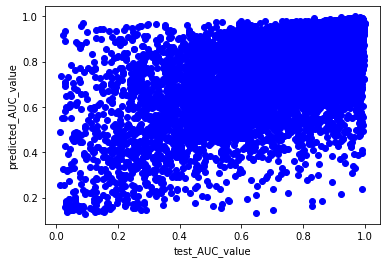

In [40]:
predicted_value = best_model.predict({'cell_input': test_cell_emb, 'drug_input': test_padel_features})
plt.scatter(test_y,predicted_value,c='blue')
plt.xlabel('test_AUC_value')
plt.ylabel('predicted_AUC_value')

In [41]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_y)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [42]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.12516871482842304


In [43]:
mae = (np.abs(b[0]-a[0])).sum()
mae / len(b)

0.07607963378353406

In [44]:
mse

0.01566720717179909

In [45]:
from sklearn.metrics import r2_score
r2_value = r2_score(b, a) 
print(r2_value)

0.5341537624253048


In [46]:
full_test = pd.read_csv('/data/yingfei/cancer_data/test_data.csv')

full_test = full_test[['ARXSPAN_ID', 'DRUG_NAME']]
eval_data = test_data_new[['ARXSPAN_ID', 'DRUG_NAME', 'auc']].copy()
eval_data['pred_auc'] = predicted_value
eval_data

,ARXSPAN_ID,DRUG_NAME,auc,pred_auc
0,ACH-000802,JW-7-24-1,0.528562,0.771284
1,ACH-000802,KIN001-260,0.930958,0.929286
2,ACH-000802,NSC-87877,0.759249,0.886555
3,ACH-000802,PLX-4720,0.936510,0.949221
4,ACH-000802,ERK5-IN-1,0.823453,0.876355
...,...,...,...,...
22873,ACH-000438,KIN001-266,0.975578,0.792989
22874,ACH-000438,LUMINESPIB,0.980529,0.989470
22875,ACH-000438,NUTLIN-3A,0.960501,0.939713
22876,ACH-000438,SGC0946,0.970524,0.985919


In [47]:
full_test['comb'] = full_test.ARXSPAN_ID + full_test.DRUG_NAME
eval_data['comb'] = eval_data.ARXSPAN_ID + eval_data.DRUG_NAME
eval_data = pd.merge(full_test, eval_data, on = ['ARXSPAN_ID', 'DRUG_NAME'], how = 'left')

In [48]:
eval_data_arr = pd.DataFrame(eval_data.ARXSPAN_ID.unique(), columns = ['ARXSPAN_ID'])
eval_data_arr['true_auc_arr'] = [[] for _ in range(len(eval_data_arr))]
eval_data_arr['pred_auc_arr'] = [[] for _ in range(len(eval_data_arr))]
eval_data_arr

,ARXSPAN_ID,true_auc_arr,pred_auc_arr
0,ACH-000802,[],[]
1,ACH-001496,[],[]
2,ACH-000267,[],[]
3,ACH-000508,[],[]
4,ACH-001106,[],[]
...,...,...,...
64,ACH-000953,[],[]
65,ACH-000561,[],[]
66,ACH-000819,[],[]
67,ACH-000873,[],[]


In [49]:
for i in range(len(eval_data)):
    cl_id = eval_data.loc[i, 'ARXSPAN_ID']
    auc = eval_data.loc[i, 'auc']
    pred_auc =  eval_data.loc[i, 'pred_auc']
    if np.isnan(auc):
        #eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'true_auc_arr'].values[0].append(1)
        #eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'pred_auc_arr'].values[0].append(1)
        continue
    eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'true_auc_arr'].values[0].append(auc)
    eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'pred_auc_arr'].values[0].append(pred_auc)

In [50]:
pred_values = eval_data_arr.pred_auc_arr.apply(lambda x: np.array(x)).to_numpy()
true_values = eval_data_arr.true_auc_arr.apply(lambda x: np.array(x)).to_numpy()

In [51]:
### NDCG
from sklearn.metrics import ndcg_score
#ndcg_all = ndcg_score([p for p in pred_values],[t for t in true_values])
#ndcg_10 = ndcg_score([p for p in pred_values],[t for t in true_values], k = 10)
ndcg_all_values = []
ndcg_10_values = []
for i in range(len(pred_values)):
    pred_value = eval_data_arr['pred_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
    true_value = eval_data_arr['true_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
    ndcg_all_values.append(ndcg_score([pred_value],[true_value]))
    ndcg_10_values.append(ndcg_score([pred_value],[true_value], k = 10))
    
ndcg_all = np.mean(ndcg_all_values)
ndcg_10 = np.mean(ndcg_10_values)

print(ndcg_all)
print(ndcg_10)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
0.9297919346287026
0.7790203166140706


In [52]:
### Recall
results = []
for top_k in [1, 2, 5, 10]:
    dict_test_cell_line_idx_perf = {}
    for cur_cell_line_idx in range(len(pred_values)):
        # step 1
        # per the ground truth
        gt_aucs = true_values[cur_cell_line_idx]
        # find the top k drugs's idx
        topk_drug_idx_gt = np.argsort(gt_aucs)[:top_k]
        # step 2
        # per the predicted scores
        pred_scores = pred_values[cur_cell_line_idx]
        assert gt_aucs.shape == pred_scores.shape
        # find the top k drugs'idx (note: here its by pred scores)
        topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
        # step 3
        # recall@k
        cur_recall_at_k = len(
            set(topk_drug_idx_pred).intersection(set(topk_drug_idx_gt))
        ) / len(set(topk_drug_idx_gt))
        dict_test_cell_line_idx_perf[cur_cell_line_idx] = cur_recall_at_k

    avg_recall_at_k = np.mean(list(dict_test_cell_line_idx_perf.values()))
    results.append((f"Recall@{top_k}", round(avg_recall_at_k, 4)))
print(results)

[('Recall@1', 0.3768), ('Recall@2', 0.3841), ('Recall@5', 0.4377), ('Recall@10', 0.4464)]


In [53]:
### AUC
results = []
for top_k in [1, 2, 5, 10]:
    dict_test_cell_line_topk_auc_sum_gt = {}
    dict_test_cell_line_topk_auc_sum_pred = {}
    for cur_cell_line_idx in range(len(pred_values)):
        # step 1
        # per the predicted scores
        pred_scores = pred_values[cur_cell_line_idx]
        # find the top k drugs'idx (note: here its by pred scores)
        topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
        # step 2
        # per the ground truth
        gt_aucs = true_values[cur_cell_line_idx]
        # find the top k predicted drugs' (per ground truth) aucs
        topk_drug_idx_gt = np.argsort(gt_aucs)[:top_k]
        dict_test_cell_line_topk_auc_sum_gt[cur_cell_line_idx] = np.mean(
            gt_aucs[topk_drug_idx_gt]
        )
        dict_test_cell_line_topk_auc_sum_pred[cur_cell_line_idx] = np.mean(
            gt_aucs[topk_drug_idx_pred]
        )

    avg_auc_topk_gt = np.mean(
        list(dict_test_cell_line_topk_auc_sum_gt.values())
    )
    avg_auc_topk_pred = np.mean(
        list(dict_test_cell_line_topk_auc_sum_pred.values())
    )

    results.append(
        (
            f"Auc@{top_k}",
            f"{round(avg_auc_topk_pred, 4)} (GT: {round(avg_auc_topk_gt, 4)})",
        )
    )

print(results)

[('Auc@1', '0.2322 (GT: 0.1198)'), ('Auc@2', '0.2998 (GT: 0.157)'), ('Auc@5', '0.3765 (GT: 0.222)'), ('Auc@10', '0.4383 (GT: 0.2893)')]


In [54]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(c.Predicted, c.Test)[0], spearmanr(c.Predicted, c.Test)[0])

0.7356457672069424 0.7265822105133795
